In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [119]:
traindata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')
mergeData = [traindata, testdata]

# 1. FEATURE ENGINEERING

## 1.1. Get Titles: based on name

In [120]:
import re

def title(Name):
    getTitle = re.search('([A-Za-z]+)\.',Name)
    
    if getTitle:
        return getTitle.group(1)
    return ""

for data in mergeData:
    data['Titles'] = data['Name'].apply(title)

crosstabTrain = pd.crosstab(traindata['Titles'], traindata['Sex'])
crosstabTest = pd.crosstab(testdata['Titles'], testdata['Sex'])

In [121]:
### check if there two sex in one title
crosstabTrain[(crosstabTrain.female != 0) & (crosstabTrain.male !=0)]

Sex,female,male
Titles,,
Dr,1,6


In [122]:
# Dr are female & male
crosstabTest[(crosstabTest.female != 0) & (crosstabTest.male !=0)]
# Just in Train data

Sex,female,male
Titles,,


## MALE

In [123]:
crosstabTest.loc[crosstabTest.male != 0, 'male'].sort_values(ascending=False)

Titles
Mr        240
Master     21
Rev         2
Col         2
Dr          1
Name: male, dtype: int64

In [124]:
#titles in data train have represent titles in data test
male = crosstabTrain.loc[crosstabTrain.male != 0, 'male'].sort_values(ascending=False)
male

Titles
Mr          517
Master       40
Rev           6
Dr            6
Major         2
Col           2
Sir           1
Jonkheer      1
Don           1
Capt          1
Name: male, dtype: int64

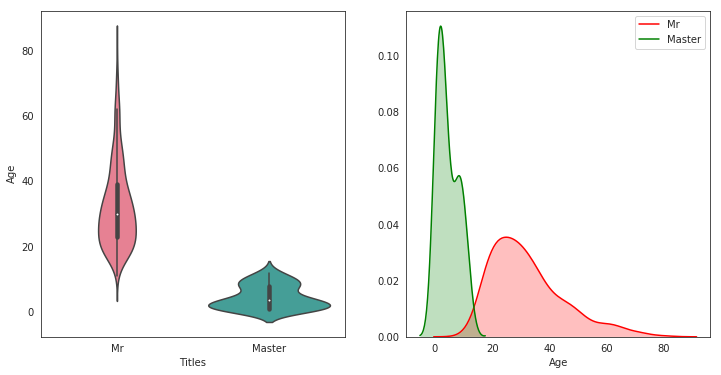

In [125]:
# Age distibution for titles: Mr. and Master
ManOld = traindata[['Titles','Age']][traindata.Titles.isin(['Mr','Master'])]

f,axes = plt.subplots(1,2, figsize=(12,6))
visManOld = sns.violinplot(data=ManOld, x='Titles', y='Age',ax=axes[0], palette="husl")


plt.rcParams['figure.figsize'] = 10,8
visMO1 = sns.distplot(ManOld[ManOld.Titles=='Mr'].Age, hist=False, kde_kws={"shade": True}, color="r", label ='Mr')
visMO1 = sns.distplot(ManOld[ManOld.Titles=='Master'].Age, hist=False, kde_kws={"shade": True}, color="g", label='Master')
visMO1.legend()

plt.show()

In [126]:
mr = ['Rev','Dr','Major', 'Col', 'Sir', 'Jonkheer', 'Don', 'Capt']
traindata[(traindata.Titles.isin(mr)) & (traindata.Age<=20)][['Titles','Age']]
#all of them greater than 20 y.o
# testdata[(testdata.Titles.isin(maleL)) & (testdata.Age<=20) ][['Titles','Age']]

,Titles,Age


In [127]:
for data in mergeData:
    data.loc[data.Titles.isin(mr) & (data.Sex == 'male'),'Titles'] = 'Mr'

In [128]:
#female Dr
traindata[traindata.Titles == 'Dr']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Dr


## FEMALE

In [129]:
crosstabTest.loc[crosstabTest.female != 0, 'female'].sort_values(ascending=False)

Titles
Miss    78
Mrs     72
Ms       1
Dona     1
Name: female, dtype: int64

In [130]:
crosstabTrain.loc[crosstabTrain.female != 0, 'female'].sort_values(ascending=False)

Titles
Miss        182
Mrs         125
Mlle          2
Ms            1
Mme           1
Lady          1
Dr            1
Countess      1
Name: female, dtype: int64

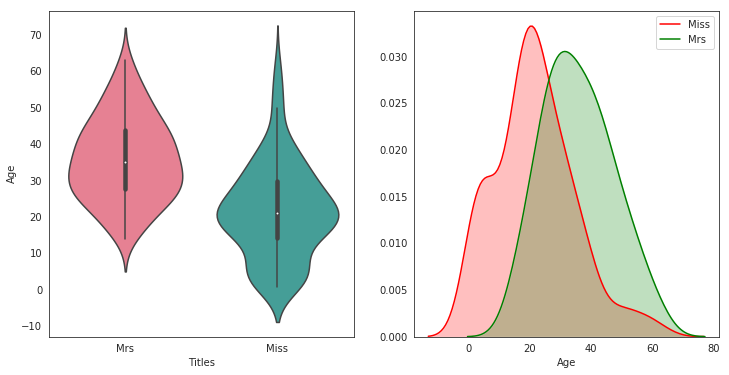

In [131]:
woman = traindata[['Titles','Age']][traindata.Titles.isin(['Miss','Mrs'])]

f,axes = plt.subplots(1,2, figsize=(12,6))
viswoman = sns.violinplot(data=woman, x='Titles', y='Age',ax=axes[0], palette="husl")


plt.rcParams['figure.figsize'] = 10,8
visMO2 = sns.distplot(woman[woman.Titles=='Miss'].Age, hist=False, kde_kws={"shade": True}, color="r", label ='Miss')
visMO2 = sns.distplot(woman[woman.Titles=='Mrs'].Age, hist=False, kde_kws={"shade": True}, color="g", label='Mrs')
visMO2.legend()

plt.show()

In [132]:
mrs = ['Mlle','Ms','Mme','Lady','Dr','Countess', 'Dona']
traindata[traindata.Titles.isin(mrs) & (traindata.Age <=20)][['Titles','Age']]
#All of them greater than 20 y.o
#testdata[testdata.Titles.isin(mrs) & (testdata.Age <=20)][['Titles','Age']]

,Titles,Age


In [133]:
for data in mergeData:
    data.loc[(data.Titles.isin(mrs))&(data.Sex == 'female'),'Titles'] = 'Mrs'

## 1.2. fillna Age: based on Titles

In [134]:
titles = ['Mr','Master','Mrs','Miss']
for title in titles:
    for data in mergeData:
        dt = data[data.Titles==title]

        ageAvg = dt.Age.mean()
        ageStd = dt.Age.std()
        ageMin = ageAvg-ageStd
        ageMax = ageAvg+ageStd
        numNull = data.Age.isnull().sum()

        ageRand = np.random.randint(ageMin,ageMax,size=numNull)
        data['Age'][np.isnan(data['Age'])] = ageRand
        #data['Age'] = data['Age'].astype('int')

## 1.3. Alone or not alone

In [135]:
for data in mergeData:
    data.loc[(data.SibSp == 0) & (data.Parch == 0), 'Alone'] = 1
    data.loc[data.Alone.isnull(), 'Alone'] = 0 
    data.Alone = data.Alone.astype('int')

## 1.4. fillna fare : based on Pclass
there is correlation between Fare & Pclass

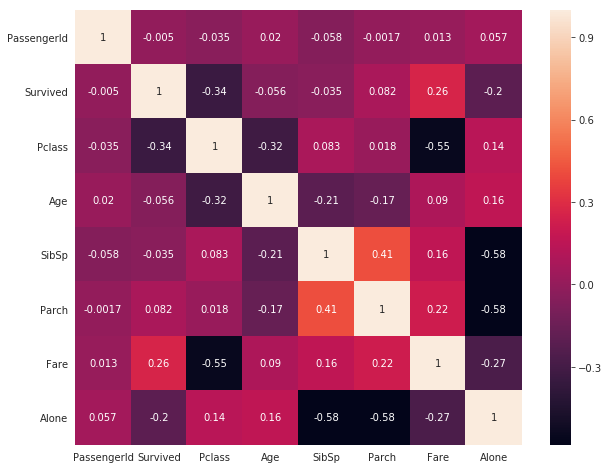

In [136]:
sns.heatmap(traindata.corr(),annot=True)
plt.show()

In [137]:
Pclass = list(traindata.Pclass.unique())
for pc in Pclass:
    for data in mergeData:
        df = data[data.Pclass == pc]
        
        fareAvg = df.Fare.mean()
        fareStd = df.Fare.std()
        fareMin = fareAvg-fareStd
        fareMax = fareAvg+fareStd
        numNull = data.Fare.isnull().sum()
        
        fareRand = np.random.randint(fareMin,fareMax,size=numNull)
        data['Fare'][np.isnan(data['Fare'])] = fareRand

## 1.5. fillna Embarked: based on mode    

In [138]:
for data in mergeData:
    data.loc[data.Embarked.isnull(),'Embarked'] = 'S'

# remove columns

In [139]:
dropColumns = ['PassengerId','Name','SibSp','Parch','Ticket','Cabin']
for data in mergeData:
    data.drop(dropColumns, axis=1,inplace=True)

# 2. CATEGORICAL

In [140]:
# Age Interval
splitAge = traindata.copy()
splitAge['Age'] = pd.cut(traindata['Age'], 5)
splitAge.groupby('Age').count()

,Survived,Pclass,Sex,Fare,Embarked,Titles,Alone
Age,,,,,,,
"(0.34, 16.336]",100,100,100,100,100,100,100
"(16.336, 32.252]",458,458,458,458,458,458,458
"(32.252, 48.168]",253,253,253,253,253,253,253
"(48.168, 64.084]",69,69,69,69,69,69,69
"(64.084, 80.0]",11,11,11,11,11,11,11


In [141]:
# Fare Interval
splitFare = traindata.copy()
splitFare['Fare'] = pd.qcut(traindata['Fare'], 6)
splitFare.groupby('Fare').count()

,Survived,Pclass,Sex,Age,Embarked,Titles,Alone
Fare,,,,,,,
"(-0.001, 7.775]",156,156,156,156,156,156,156
"(7.775, 8.662]",152,152,152,152,152,152,152
"(8.662, 14.454]",139,139,139,139,139,139,139
"(14.454, 26.0]",149,149,149,149,149,149,149
"(26.0, 52.369]",146,146,146,146,146,146,146
"(52.369, 512.329]",149,149,149,149,149,149,149


In [142]:
for data in mergeData:
    #AGE
    data.loc[data.Age <= 16.3, 'Age'] = 0
    data.loc[(data.Age >16.3) & (data.Age <= 32.3), 'Age'] = 1
    data.loc[(data.Age >32.3) & (data.Age <= 48.2), 'Age'] = 2
    data.loc[(data.Age >48.2) & (data.Age <= 64.1), 'Age'] = 3
    data.loc[data.Age > 64.1, 'Age'] = 4   
    
    #FARE
    data.loc[data.Fare <= 7.8, 'Fare'] = 0
    data.loc[(data.Fare > 7.8)&(data.Fare <= 8.7), 'Fare'] = 1
    data.loc[(data.Fare > 8.7)&(data.Fare <= 14.5), 'Fare'] = 2
    data.loc[(data.Fare > 14.5)&(data.Fare <= 26.0), 'Fare'] = 3
    data.loc[(data.Fare > 26.0)&(data.Fare <= 52.4), 'Fare'] = 4
    data.loc[(data.Fare > 52.4), 'Fare'] = 5
    
    data['Sex'] = data['Sex'].map({'female':0,'male':1}).astype('int')
    data['Titles'] = data['Titles'].map({'Mr':0, 'Mrs':1, 'Miss':2, 'Master':3})
    data['Embarked'] = data['Embarked'].map({'Q':0, 'C':1, 'S':2})
    
    data['Age'] = data['Age'].astype(int)
    data['Fare'] = data['Fare'].astype(int)
    data['Embarked'] = data['Embarked'].astype(int)

In [143]:
trainData = traindata[['Embarked','Titles','Pclass','Sex','Age','Fare','Alone','Survived']]
testData= testdata[['Embarked','Titles','Pclass','Sex','Age','Fare','Alone']]

In [144]:
trainData.to_csv('CleanTrainDel.csv',index=False)
testData.to_csv('CleanTestDel.csv', index=False)

In [175]:
trainData = pd.read_csv('CleanTrainDel.csv')
testData = pd.read_csv('CleanTestDel.csv')

In [181]:
X = trainData.iloc[:,:-1].values
y = trainData.iloc[:,7:8].values

In [182]:
X.shape

(891, 7)

# 3. ONEHOTENCODER 
Embarked & Titles

In [183]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# EMBARKED
onehotencoderE = OneHotEncoder(categorical_features = [0])
X = onehotencoderE.fit_transform(X).toarray()
#avoiding dummy var trap
X = X[:,1:]

#TITLES
onehotencoderT = OneHotEncoder(categorical_features = [2])
X = onehotencoderT.fit_transform(X).toarray()
#avoiding dummy var trap
X = X[:,1:]

# 4. BACKWARD ELIMINATION
the optimum model, without Fare & Alone

In [184]:
import statsmodels.formula.api as sm
# ADD BIAS FIRST
X = np.append(arr = np.ones((891,1)).astype(int), values=X, axis=1)

In [186]:
X_opt = X[:,[0,1,2,3,5,6,7,8,10]] #remove index that have Pvalues > Significant Level
cekOLS = sm.OLS(endog = y, exog=X_opt).fit()
cekOLS.summary()

#X -- bias=0 #Embarked=1 #Titles=2 #Pclass=3 #Sex=4 #Age=5 ##Fare=6 ##Alone=7
#constant has index 0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     90.84
Date:                Thu, 31 Jan 2019   Prob (F-statistic):           1.43e-99
Time:                        13:42:30   Log-Likelihood:                -380.33
No. Observations:                 891   AIC:                             776.7
Df Residuals:                     883   BIC:                             815.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7661      0.041     18.661      0.000       0.686       0.847
x1             0.4986      0.030     16.464      0.000       0.439       0.558
x2             0.3884      0.025     15.455      0.000       0.339       0.438
x3             0.4665      0.068      6.863      0.000       0.333       0.600
x4            -0.0828      0.028     -2.926      0.004      -0.138      -0.027
x5            -0.1767      0.016    -10.936      0.000      -0.208      -0.145
x6            -0.1209      0.025     -4.815      0.000      -0.170      -0.072
x7            -0.0437      0.017     -2.496      0.013      -0.078      -0.009
x8             0.0820      0.030      2.772      0.006       0.024       0.140
==============================================================================
Omnibus:                       34.860   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.927
Skew:                           0.491   Prob(JB):                     5.81e-09
Kurtosis:                       3.236   Cond. No.                     1.09e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.46e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 5. NEURAL NETWORK

In [187]:
X = X[:,[0,1,2,3,5,6,7,8,10]]
y = y

In [188]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval = train_test_split(X,y,stratify=y, test_size=0.3)

In [190]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

def sigmoidGradient(z):
    return(sigmoid(z)*(1-sigmoid(z)))

In [191]:
def getOptTheta(nn_params, input_layer_size, hidden_layer_size, num_labels, features, classes, reg,alpha,num_iter):
    
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size,(input_layer_size+1))
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels,(hidden_layer_size+1))

    m = features.shape[0]
    if num_labels == 1:
        y_matrix = classes
    else:
        y_matrix = pd.get_dummies(classes.ravel()).as_matrix() 
        
    for i in np.arange(num_iter):
        
        # Cost
        a1 = features 

        z2 = theta1.dot(a1.T) 
        a2 = np.c_[np.ones((features.shape[0],1)),sigmoid(z2.T)] 

        z3 = theta2.dot(a2.T) 
        a3 = sigmoid(z3)

        # Gradients
        d3 = a3.T - y_matrix 
        d2 = theta2[:,1:].T.dot(d3.T)*sigmoidGradient(z2) 

        delta1 = d2.dot(a1) 
        delta2 = d3.T.dot(a2)

        theta1_ = np.c_[np.ones((theta1.shape[0],1)),theta1[:,1:]]
        theta2_ = np.c_[np.ones((theta2.shape[0],1)),theta2[:,1:]]

        theta1_grad = delta1/m + (theta1_*reg)/m
        theta2_grad = delta2/m + (theta2_*reg)/m

        theta1 = theta1 - (alpha*theta1_grad)
        theta2 = theta2 - (alpha*theta2_grad)
        
    return(theta1,theta2)

In [192]:
def prediction(X,thetaOpt1,thetaOpt2):
    [m,n] = X.shape
    
    a1 = X 
    a2 = sigmoid(X.dot(thetaOpt1.T) ) 
    hypo = sigmoid(np.c_[np.ones((a2.shape[0],1)),a2].dot(thetaOpt2.T)) 
    
    if thetaOpt2.shape[0] == 1:
        for i in range(hypo.shape[0]):
            if hypo[i] >= 0.5:
                hypo[i] = 1
            else:
                hypo[i] = 0
        opt = hypo
        
    else:
        opt = (np.argmax(hypo, axis=1))
        opt = opt.reshape(-1,1)
    
    return(opt)  

# 6. MODEL SELECTION

## 6.1. Model Selection: Hidden Layer Size

In [202]:
list_hidden_layer_size = [6,7,8,9,10,12,16,21,31]

reg=0.01
alpha= 0.1
num_iter=10000

input_layer_size = 8
num_labels = 1
#--------------------------------

AThl = []
AVhl = []

for hidden_layer_size in list_hidden_layer_size:
    
    #create initial random params
    eps = 0.12
    initialTheta1 = np.random.rand(hidden_layer_size,input_layer_size+1)*2*eps-eps
    initialTheta2 = np.random.rand(num_labels,hidden_layer_size+1)*2*eps-eps
    initial_nn_params = np.r_[initialTheta1.ravel(), initialTheta2.ravel()]
    
    [tOpt1,tOpt2] = getOptTheta(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, Xtrain, ytrain, reg,alpha,num_iter)
        
     
    predTrain = prediction(Xtrain,tOpt1,tOpt2)
    accTrain = np.mean(predTrain==ytrain)*100
    
    predVal = prediction(Xval,tOpt1,tOpt2)
    accVal = np.mean(predVal==yval)*100
    
    AThl.append(accTrain)
    AVhl.append(accVal)

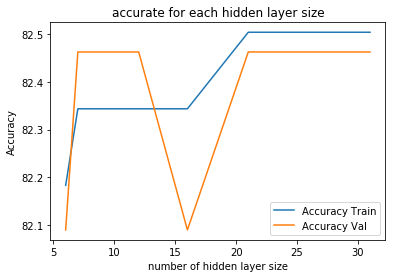

In [203]:
plt.plot(list_hidden_layer_size,AThl, label = 'Accuracy Train' )
plt.plot(list_hidden_layer_size,AVhl, label='Accuracy Val')
plt.title('accurate for each hidden layer size')
plt.xlabel('number of hidden layer size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [206]:
gethl = pd.DataFrame({'hidden_layer_size':list_hidden_layer_size,'Train Accuracy':AThl,'Val Accuracy':AVhl})
gethl.sort_values('Val Accuracy', ascending=False)

,hidden_layer_size,Train Accuracy,Val Accuracy
1,7,82.343499,82.462687
2,8,82.343499,82.462687
3,9,82.343499,82.462687
4,10,82.343499,82.462687
5,12,82.343499,82.462687
7,21,82.504013,82.462687
8,31,82.504013,82.462687
0,6,82.182986,82.089552
6,16,82.343499,82.089552


## 6.2. Model Selection: Lambda (regularization)

In [207]:
list_reg=[0, 0.01, 0.1, 1, 10, 100]

alpha= 0.1
num_iter=10000

hidden_layer_size = 7
input_layer_size = 8
num_labels = 1
#--------------------------------

ATlr = []
AVlr = []

for reg in list_reg:
    
    #CREATE INITIAL RANDOM PARAMS
    eps = 0.12
    initialTheta1 = np.random.rand(hidden_layer_size,input_layer_size+1)*2*eps-eps
    initialTheta2 = np.random.rand(num_labels,hidden_layer_size+1)*2*eps-eps
    initial_nn_params = np.r_[initialTheta1.ravel(), initialTheta2.ravel()]
    
    [tOpt1,tOpt2] = getOptTheta(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, Xtrain, ytrain, reg,alpha,num_iter)
        
     
    predTrain = prediction(Xtrain,tOpt1,tOpt2)
    accTrain = np.mean(predTrain==ytrain)*100
    
    predVal = prediction(Xval,tOpt1,tOpt2)
    accVal = np.mean(predVal==yval)*100
    
    ATlr.append(accTrain)
    AVlr.append(accVal)

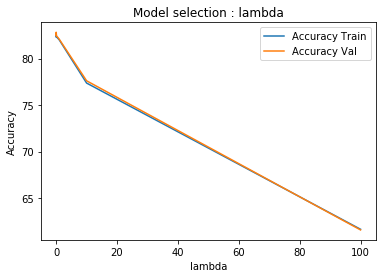

In [208]:
plt.plot(list_reg,ATlr, label = 'Accuracy Train' )
plt.plot(list_reg,AVlr, label='Accuracy Val')
plt.title('Model selection : lambda')
plt.xlabel('lambda')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [209]:
getlr = pd.DataFrame({'Lambda - reg':list_reg,'Train Accuracy':ATlr,'Val Accuracy':AVlr})
getlr.sort_values('Val Accuracy', ascending=False)

,Lambda - reg,Train Accuracy,Val Accuracy
1,0.01,82.504013,82.835821
0,0.00,82.343499,82.462687
2,0.10,82.343499,82.462687
3,1.00,82.022472,82.089552
4,10.00,77.367576,77.611940
5,100.00,61.637239,61.567164


## 6.3. Model Selection: NumIters for GradientDescent

In [210]:
numIters=[1000,2000,3000,4000,5000,10000,15000,20000,25000,30000]

reg=0.01
alpha= 0.1

hidden_layer_size = 7
input_layer_size = 8
num_labels = 1
#--------------------------------

ATni = []
AVni = []

for num_iter in numIters:
    
    #CREATE INITIAL RANDOM PARAMS
    eps = 0.12
    initialTheta1 = np.random.rand(hidden_layer_size,input_layer_size+1)*2*eps-eps
    initialTheta2 = np.random.rand(num_labels,hidden_layer_size+1)*2*eps-eps
    initial_nn_params = np.r_[initialTheta1.ravel(), initialTheta2.ravel()]
    
    [tOpt1,tOpt2] = getOptTheta(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, Xtrain, ytrain, reg,alpha,num_iter)
        
     
    predTrain = prediction(Xtrain,tOpt1,tOpt2)
    accTrain = np.mean(predTrain==ytrain)*100
    
    predVal = prediction(Xval,tOpt1,tOpt2)
    accVal = np.mean(predVal==yval)*100
    
    ATni.append(accTrain)
    AVni.append(accVal)

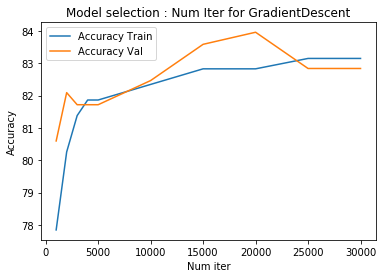

In [211]:
plt.plot(numIters,ATni, label = 'Accuracy Train' )
plt.plot(numIters,AVni, label='Accuracy Val')
plt.title('Model selection : Num Iter for GradientDescent')
plt.xlabel('Num iter')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [213]:
getni = pd.DataFrame({'Num Iters':numIters,'Train Accuracy':ATni,'Val Accuracy':AVni})
getni.sort_values('Val Accuracy', ascending=False)

,Num Iters,Train Accuracy,Val Accuracy
7,20000,82.825040,83.955224
6,15000,82.825040,83.582090
8,25000,83.146067,82.835821
9,30000,83.146067,82.835821
5,10000,82.343499,82.462687
1,2000,80.256822,82.089552
2,3000,81.380417,81.716418
3,4000,81.861958,81.716418
4,5000,81.861958,81.716418
0,1000,77.849117,80.597015


## 6.4.Model Selection: Alpha

In [214]:
alphaL= [0.01,0.03,0.1,0.3,1,3]

reg=0.01
num_iter=20000

hidden_layer_size = 7
input_layer_size = 8
num_labels = 1
#--------------------------------

ATa = []
AVa = []

for alpha in alphaL:
    
    #CREATE INITIAL RANDOM PARAMS
    eps = 0.12
    initialTheta1 = np.random.rand(hidden_layer_size,input_layer_size+1)*2*eps-eps
    initialTheta2 = np.random.rand(num_labels,hidden_layer_size+1)*2*eps-eps
    initial_nn_params = np.r_[initialTheta1.ravel(), initialTheta2.ravel()]
    
    [tOpt1,tOpt2] = getOptTheta(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, Xtrain, ytrain, reg,alpha,num_iter)
        
     
    predTrain = prediction(Xtrain,tOpt1,tOpt2)
    accTrain = np.mean(predTrain==ytrain)*100
    
    predVal = prediction(Xval,tOpt1,tOpt2)
    accVal = np.mean(predVal==yval)*100
    
    ATa.append(accTrain)
    AVa.append(accVal)
    

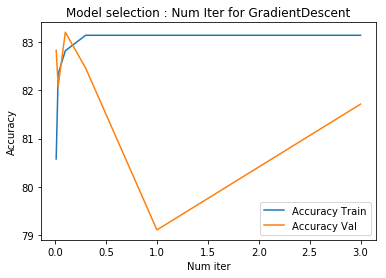

In [215]:
plt.plot(alphaL,ATa, label = 'Accuracy Train' )
plt.plot(alphaL,AVa, label='Accuracy Val')
plt.title('Model selection : Num Iter for GradientDescent')
plt.xlabel('Num iter')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [217]:
geta = pd.DataFrame({'Alpha - learning rate':alphaL,'Train Accuracy':ATa,'Val Accuracy':AVa})
geta.sort_values('Val Accuracy', ascending=False)

,Alpha - learning rate,Train Accuracy,Val Accuracy
2,0.10,82.825040,83.208955
0,0.01,80.577849,82.835821
3,0.30,83.146067,82.462687
1,0.03,82.343499,82.089552
5,3.00,83.146067,81.716418
4,1.00,83.146067,79.104478


## 🌹get different initial_nn_params and different accuracy 🌹

In [221]:
accuracyTrainLr = []
accuracyValLr = []
tOptl1 = []
tOptl2 = []

trying = np.arange(1,11)
for iters in trying:

    reg=0.01
    alpha= 0.1
    num_iter=20000

    hidden_layer_size = 7
    input_layer_size = 8
    num_labels = 1
    #--------------------------------

    #CREATE INITIAL RANDOM PARAMS
    eps = 0.12
    initialTheta1 = np.random.rand(hidden_layer_size,input_layer_size+1)*2*eps-eps
    initialTheta2 = np.random.rand(num_labels,hidden_layer_size+1)*2*eps-eps
    initial_nn_params = np.r_[initialTheta1.ravel(), initialTheta2.ravel()]

    [tOpt1,tOpt2] = getOptTheta(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, Xtrain, ytrain, reg,alpha,num_iter)


    predTrain = prediction(Xtrain,tOpt1,tOpt2)
    accTrain = np.mean(predTrain==ytrain)*100

    predVal = prediction(Xval,tOpt1,tOpt2)
    accVal = np.mean(predVal==yval)*100

    accuracyTrainLr.append(accTrain)
    accuracyValLr.append(accVal)
    tOptl1.append(tOpt1)
    tOptl2.append(tOpt2)

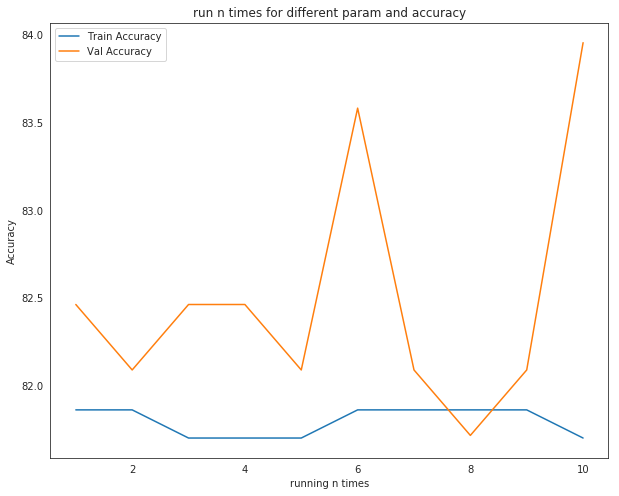

In [225]:
plt.plot(trying,accuracyTrainLr, label = 'Train Accuracy' )
plt.plot(trying,accuracyValLr, label='Val Accuracy')
plt.title('run n times for different param and accuracy')
plt.xlabel('running n times')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [195]:
tri = accuracyTrainLr.index(np.max(accuracyTrainLr))
trv = np.max(accuracyTrainLr)
tvi = accuracyValLr.index(np.max(accuracyValLr))
tvv = np.max(accuracyValLr)
print('the highest accuracy in data train in index:',tri,'with accuracy =',trv)
print('the highest accuracy in data CROSSVAL in index:',tvi,'with accuracy =',tvv)

the highest accuracy in data train in index: 1 with accuracy = 81.86195826645265
the highest accuracy in data CROSSVAL in index: 5 with accuracy = 83.95522388059702


## get the optimum theta

In [196]:
imax = accuracyValLr.index(np.max(accuracyValLr))

In [197]:
Theta1Optimum = tOptl1[imax]
Theta2Optimum = tOptl2[imax]

In [226]:
predTrain = prediction(Xtrain,Theta1Optimum,Theta2Optimum)
accTrain = np.mean(predTrain==ytrain)*100
accTrain

81.86195826645265

In [201]:
predVal = prediction(Xval,Theta1Optimum,Theta2Optimum)
accVal = np.mean(predVal==yval)*100
accVal

83.95522388059702

# 7. EVALUATION

In [202]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

In [203]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style('white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 7.1. Confusion Matrix

Recall = 0.67
Precision = 0.88
Accuracy= 0.8395522388059702


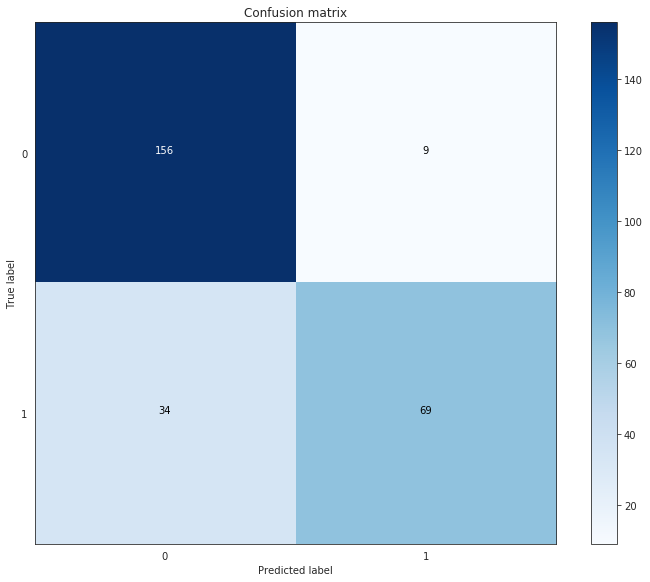

In [204]:
cm = confusion_matrix(yval,predVal)

#bukan make index untuk akses confusion matrix. 
print("Recall =", round(cm[1,1]/(cm[1,0]+cm[1,1]),2))
print("Precision =",round(cm[1,1]/(cm[0,1]+cm[1,1]),2))
print("Accuracy=",(cm[1,1]+cm[0,0])/(cm[1,1]+cm[0,0]+cm[1,0]+cm[0,1]) )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [205]:
print(classification_report(yval,predVal))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       165
           1       0.88      0.67      0.76       103

   micro avg       0.84      0.84      0.84       268
   macro avg       0.85      0.81      0.82       268
weighted avg       0.85      0.84      0.83       268



## 7.2. ROC Curve

ROC AUC= 80.77 %


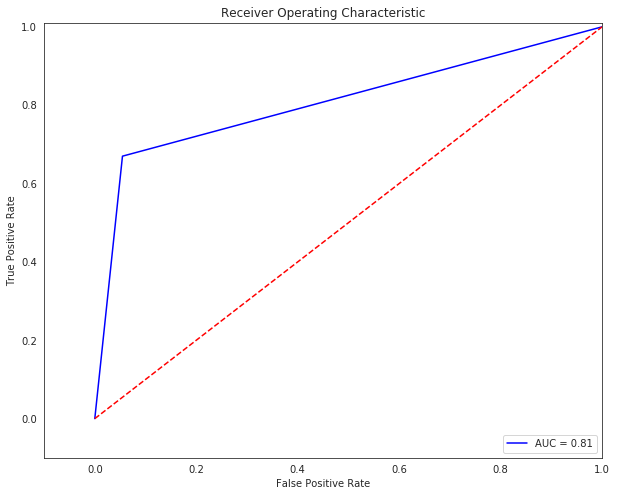

In [206]:
fpr, tpr, thresholds = roc_curve(yval,predVal)
roc_auc = auc(fpr,tpr)

print('ROC AUC=',round((roc_auc*100),2),'%')
# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 8. PREDICTING TEST DATA

In [207]:
testData.iloc[:,:-2].head(5)

,Embarked,Titles,Pclass,Sex,Age
0,0,0,3,1,2
1,2,1,3,0,2
2,0,0,2,1,3
3,2,0,3,1,1
4,2,1,3,0,1


In [167]:
testData.head(3)

,Embarked,Titles,Pclass,Sex,Age,Fare,Alone
0,0,0,3,1,2,1,1
1,2,1,3,0,2,0,0
2,0,0,2,1,3,2,1


In [208]:
Xtest = testData.iloc[:,:].values
Xtest.shape

(418, 7)

## OneHotEncoder Embarked & Titles

In [209]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#EMBARKED
onehotencoderXtestE = OneHotEncoder(categorical_features = [0])
Xtest = onehotencoderXtestE.fit_transform(Xtest).toarray()
#avoiding dummy variable trap
Xtest= Xtest[:,1:]

#TITLES
onehotencoderXtestT = OneHotEncoder(categorical_features = [2])
Xtest = onehotencoderXtestT.fit_transform(Xtest).toarray()
#avoiding dummy variable trap
Xtest= Xtest[:,1:]


In [210]:
Xtest = np.c_[np.ones((Xtest.shape[0])),Xtest]
Xtest.shape

(418, 11)

In [211]:
Xtest = Xtest[:,[0,1,2,3,5,6,7,8,10]]

In [212]:
Xtest.shape

(418, 9)

In [213]:
predTest = prediction(Xtest,Theta1Optimum,Theta2Optimum)